<a href="https://colab.research.google.com/github/oseghr/MachineLearning/blob/main/classifying_clothing_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install and import dependencies
!pip install -U tensorflow_datasets


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
# Import the fashion MNIST dataset
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
class_names = metadata.features['label'].names
print(f"Class names: {class_names}")

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
# Explore the data imported
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print(f"Number of training examples: {num_train_examples}")
print(f"Number of test examples: {num_test_examples}")

Number of training examples: 60000
Number of test examples: 10000


In [6]:
# Preprpocessing of the data
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

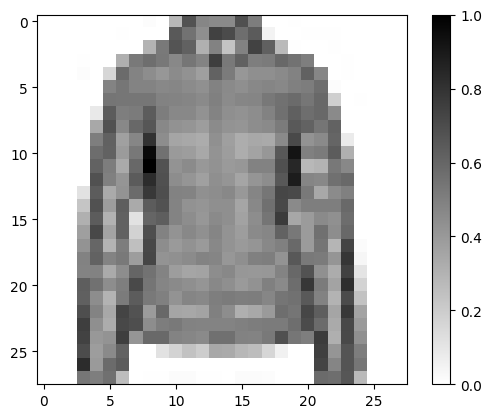

In [11]:
# Explore the processed data
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28, 28))

# Plot the image of clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


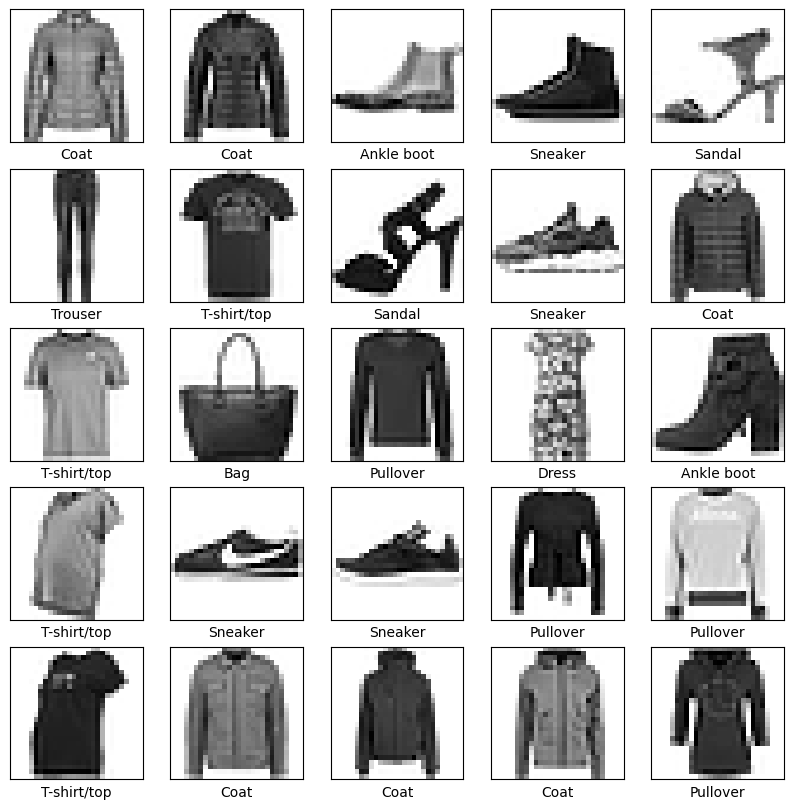

In [12]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(test_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [15]:
# Building the model
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(10)
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])


# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# Train the model

BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 20s 6ms/step - loss: 0.4932 - accuracy: 0.8254
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3753 - accuracy: 0.8651
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3339 - accuracy: 0.8783
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3098 - accuracy: 0.8865
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2959 - accuracy: 0.8907


In [17]:
# Evaluating the accuracy of the model
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 0.3801 - accuracy: 0.8610
Accuracy on test dataset: 0.8610000014305115


In [20]:
# Make a prediction from the test dataset
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

predictions.shape
predictions[0]
np.argmax(predictions[0])
test_labels[0]

1/1 [==============================] - 0s 23ms/step


4

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

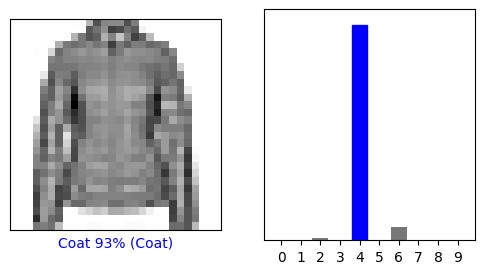

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

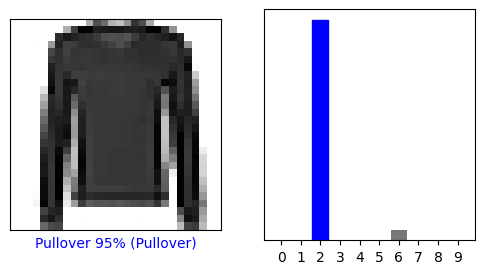

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()